##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Building off of the comparisons made in the [MNIST](https://www.tensorflow.org/quantum/tutorials/mnist) tutorial, this tutorial explores the recent work of [Huang et al.](https://arxiv.org/abs/2011.01938) that shows how different datasets affect performance comparisons. In the work, the authors seek to understand how and when classical machine learning models can learn as well as (or better than) quantum models. The work also showcases an empirical performance separation between classical and quantum machine learning model via a carefully crafted dataset. You will:

1.   Prepare a reduced dimension Fashion-MNIST dataset.
2.   Use quantum circuits to re-label the dataset and compute Projected Quantum Kernel features (PQK).
3.   Train a classical neural network on the re-labeled dataset and compare the performance with a model that has access to the PQK features.

## Setup

In [7]:
import cirq
import sympy
import os
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)

### 2.2 Re-labeling based on PQK features
Now that you have these quantum generated features in `x_train_pqk` and `x_test_pqk`, it is time to re-label the dataset. To achieve maximum seperation between quantum and classical performance you can re-label the dataset based on the spectrum information found in `x_train_pqk` and `x_test_pqk`.

Note: This preparation of your dataset to explicitly maximize the seperation in performance between the classical and quantum models might feel like cheating, but it provides a **very** important proof of existance for datasets that are hard for classical computers and easy for quantum computers to model. There would be no point in searching for quantum advantage in QML if you couldn't first create something like this to demonstrate advantage.

In [11]:
DATASET_DIM = 10
N_TRAIN = 800 
N_TEST = 200
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
path = os.getcwd()
x_train = np.load(path+"/Notebook_dataset/x_train.npy")
x_test = np.load(path+"/Notebook_dataset/x_test.npy")
y_train = np.load(path+"/Notebook_dataset/y_train.npy")
y_test = np.load(path+"/Notebook_dataset/y_test.npy")

x_train_pqk = tf.convert_to_tensor(np.load(path + "/x_train_pqk_pennylane.npy"))
x_test_pqk = tf.convert_to_tensor(np.load(path + "/x_test_pqk_pennylane.npy"))
y_train_new = tf.convert_to_tensor(np.load(path + "/y_train_new_MNIST.npy"))
y_test_new = tf.convert_to_tensor(np.load(path + "/y_test_new_MNIST.npy"))

print(np.shape(x_train_pqk))
print(np.shape(x_test_pqk))
print(np.shape(y_train_new))
print(np.shape(y_test_new))

(800, 33)
(200, 33)
(800,)
(200,)


Now you have everything you need to re-label the dataset! Now you can consult with the flowchart to better understand how to maximize performance seperation when re-labeling the dataset:

<img src="./images/quantum_data_1.png">

In order to maximize the seperation between quantum and classical models, you will attempt to maximize the geometric difference between the original dataset and the PQK features kernel matrices $g(K_1 || K_2) = \sqrt{ || \sqrt{K_2} K_1^{-1} \sqrt{K_2} || _\infty}$ using `S_pqk, V_pqk` and `S_original, V_original`. A large value of $g$ ensures that you initially move to the right in the flowchart down towards a prediction advantage in the quantum case.

Note: Computing quantities for $s$ and $d$ are also very useful when looking to better understand performance seperations. In this case ensuring a large $g$ value is enough to see performance seperation.

## 3. Comparing models
Now that you have prepared your dataset it is time to compare model performance. You will create two small feedforward neural networks and compare performance when they are given access to the PQK features found in `x_train_pqk`.

### 3.1 Create PQK enhanced model
Using standard `tf.keras` library features you can now create and a train a model on the `x_train_pqk` and `y_train_new` datapoints:

In [12]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                1088      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [4]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))

### 3.2 Create a classical model
Similar to the code above you can now also create a classical model that doesn't have access to the PQK features in your stilted dataset. This model can be trained using `x_train` and `y_label_new`.

In [13]:
#docs_infra: no_execute
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                352       
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [14]:
#docs_infra: no_execute
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(x_test, y_test_new))

### 3.3 Compare performance
Now that you have trained the two models you can quickly plot the performance gaps in the validation data between the two. Typically both models will achieve > 0.9 accuaracy on the training data. However on the validation data it becomes clear that only the information found in the PQK features is enough to make the model generalize well to unseen instances.

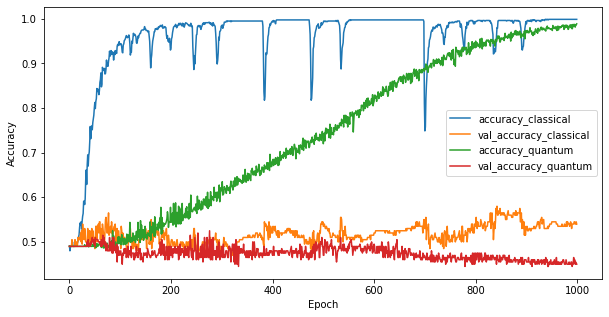

In [15]:
#docs_infra: no_execute
plt.figure(figsize=(10,5))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()